### 1. 安装依赖库

### 2. 导入依赖库

In [1]:
import jieba
import pandas as pd
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

### 3. 数据加载

In [2]:
train_data = pd.read_csv('data/train.tsv', sep='\t')
valid_data = pd.read_csv('data/dev.tsv', sep='\t')
test_data = pd.read_csv('data/test.tsv', sep='\t') 
x_train, y_train = train_data.text_a.values, train_data.label.values # 训练集
x_valid, y_valid = valid_data.text_a.values, valid_data.label.values # 验证集
x_test, y_test = test_data.text_a.values, test_data.label.values # 测试集

In [3]:
train_data

,label,text_a
0,1,选择珠江花园的原因就是方便，有电动扶梯直接到达海边，周围餐馆、食廊、商场、超市、摊位一应俱全...
1,1,15.4寸笔记本的键盘确实爽，基本跟台式机差不多了，蛮喜欢数字小键盘，输数字特方便，样子也很...
2,0,房间太小。其他的都一般。。。。。。。。。
3,0,"1.接电源没有几分钟,电源适配器热的不行. 2.摄像头用不起来. 3.机盖的钢琴漆，手不能摸..."
4,1,"今天才知道这书还有第6卷,真有点郁闷:为什么同一套书有两种版本呢?当当网是不是该跟出版社商量..."
...,...,...
9141,1,看过该书，感觉中医暂时不会消亡，尚有一、二十株老树活着，还有毛以林、黄煌、刘力红等一批有一定...
9142,0,这本书没读到底，不是特别喜欢。完全可以用序中的评价来表达我的感受：可以包容，却不想实践。除了...
9143,1,"虽是观景房,不过我住的楼层太低(19楼)看不到江景,但地点很好,离轻轨临江门站和较场口站(起..."
9144,1,性价比不错，交通方便。行政楼层感觉很好，只是早上8点楼上装修，好吵。 中餐厅档次太低，虽然便...


In [4]:
x_train, y_train

(array(['选择珠江花园的原因就是方便，有电动扶梯直接到达海边，周围餐馆、食廊、商场、超市、摊位一应俱全。酒店装修一般，但还算整洁。 泳池在大堂的屋顶，因此很小，不过女儿倒是喜欢。 包的早餐是西式的，还算丰富。 服务吗，一般',
        '15.4寸笔记本的键盘确实爽，基本跟台式机差不多了，蛮喜欢数字小键盘，输数字特方便，样子也很美观，做工也相当不错',
        '房间太小。其他的都一般。。。。。。。。。', ...,
        '虽是观景房,不过我住的楼层太低(19楼)看不到江景,但地点很好,离轻轨临江门站和较场口站(起点)很近,解放碑就在附近(大约100多公尺吧)!',
        '性价比不错，交通方便。行政楼层感觉很好，只是早上8点楼上装修，好吵。 中餐厅档次太低，虽然便宜，但是和酒店档次不相配。',
        '跟心灵鸡汤没什么本质区别嘛，至少我不喜欢这样读经典，把经典都解读成这样有点去中国化的味道了'], dtype=object),
 array([1, 1, 0, ..., 1, 1, 0], dtype=int64))

### 4. 构建词汇表

修改1： 去除停用词

In [5]:
from collections import Counter

vocab = set()
cut_docs = [" ".join(jieba.cut(x)) for x in train_data.text_a.values]
cut_docs = list(cut_docs)
print("Most common words : \n{} \n".format(Counter(" ".join(cut_docs).split()).most_common(20)))

# 创建停用词列表
stopword_path = 'data/chinese_stopwords.txt'
def get_stop_words():
    stopwords = [line.strip() for line in open(stopword_path, encoding='UTF-8').readlines()]
    stopwords += [",", "'"]
    return stopwords
stopwords = get_stop_words()

# 去除停用词
segs_without_stop = []
for sentence in cut_docs:
    sentWords = [x.strip() for x in sentence.split(' ') if x.strip() and x.strip() not in stopwords]
    segs_without_stop.append(' '.join(sentWords))

for doc in segs_without_stop:
    for word in doc:
        if word.strip():
            vocab.add(word.strip())

segs = segs_without_stop
print('-' * 20 + 'text after dropping the stopwords ' + '-' * 20)
print("Total number: {}".format(len(segs)))
print("Average length: {}".format(np.mean([len(sentence.split()) for sentence in segs])))
print("Max length: {}".format(np.max([len(sentence.split()) for sentence in segs])))
print("Min length: {}".format(np.min([len(sentence.split()) for sentence in segs])))
text_seg = " ".join(segs)
c = Counter(text_seg.split()).most_common(20)
print("Most common words : \n{} \n".format(c))

# 将词表写入本地vocab.txt文件
with open('data/vocab.txt', 'w') as file:
    for word in  vocab:
        file.write(word)
        file.write('\n')

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\86180\AppData\Local\Temp\jieba.cache
Loading model cost 0.612 seconds.
Prefix dict has been built successfully.


Most common words : 
[('，', 53056), ('的', 36867), ('。', 20583), ('了', 13389), ('是', 9424), (',', 8162), ('我', 8160), ('很', 6124), ('！', 5411), ('也', 5158), ('在', 4576), ('酒店', 4312), ('不', 4242), ('都', 4110), ('有', 4100), ('就', 3695), ('.', 3681), ('没有', 3197), ('还', 3098), ('房间', 3077)] 

--------------------text after dropping the stopwords --------------------
Total number: 9146
Average length: 36.85928274655587
Max length: 13236
Min length: 0
Most common words : 
[('酒店', 4312), ('没有', 3197), ('房间', 3077), ('不错', 2666), ('说', 2135), ('本书', 1860), ('一个', 1848), ('感觉', 1818), ('比较', 1690), ('买', 1681), ('服务', 1601), ('书', 1522), ('住', 1487), ('非常', 1378), ('喜欢', 1192), ('入住', 1191), ('!', 1164), ('没', 1146), ('会', 1119), ('知道', 959)] 



In [6]:
len(vocab)

4221

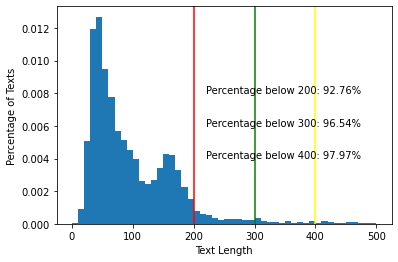

In [7]:
# plot the percentage of text
import matplotlib.pyplot as plt

plt.hist([len(text) for text in segs], bins=50 , range=(0,500), density=True)
plt.xlabel('Text Length')
plt.ylabel('Percentage of Texts')
# draw a line in 200 and calculate the percentage below 200
plt.axvline(x=200, c='red')
plt.text(220, 0.008, 'Percentage below 200: {:.2f}%'.format(len([len(text) for text in segs if len(text) <= 200])/len(segs)*100))
# draw a line in 300 and calculate the percentage below 300
plt.axvline(x=300, c='green')
plt.text(220, 0.006, 'Percentage below 300: {:.2f}%'.format(len([len(text) for text in segs if len(text) <= 300])/len(segs)*100))
# draw a line in 400 and calculate the percentage below 400
plt.axvline(x=400, c='yellow')
plt.text(220, 0.004, 'Percentage below 400: {:.2f}%'.format(len([len(text) for text in segs if len(text) <= 400])/len(segs)*100))
plt.show()


### 5. 定义配置参数

In [8]:
class Config():
    embedding_dim = 500 # 词向量维度
    max_seq_len = 400 # 文章最大词数
    vocab_file = 'data/vocab.txt' # 词汇表文件路径
config = Config()

### 6. 定义预处理类

1. 去除停用词

In [9]:

class Preprocessor():
    def __init__(self, config):
        self.config = config
        # 初始化词和id的映射词典，预留0给padding字符，1给词表中未见过的词
        token2idx = {"[PAD]": 0, "[UNK]": 1} # {word：id}
        with open(config.vocab_file, 'r') as reader:
            for index, line in enumerate(reader):
                token = line.strip()
                token2idx[token] = index + 2 # 从2开始编号
                
        self.token2idx = token2idx
        
    def transform(self, text_list):
        # 去除停用词
        segs_without_stop = []
        for sentence in text_list:
            sentence = re.sub(r'[^\u4e00-\u9fa5]+',' ',sentence)
            sentWords = [x.strip() for x in sentence.split(' ') if x.strip() and x.strip() not in stopwords]
            segs_without_stop.append(' '.join(sentWords))
        # 文本分词，并将词转换成相应的id, 最后不同长度的文本padding长统一长度，后面补0
        idx_list = [[self.token2idx.get(word.strip(), self.token2idx['[UNK]']) for word in text] for text in segs_without_stop]
        # for i in range(len(idx_list)):
        #     # print其idx和对应的词
        #     print(idx_list[i], [list(self.token2idx.keys())[list(self.token2idx.values()).index(idx)] for idx in idx_list[i]])
        idx_padding = pad_sequences(idx_list, self.config.max_seq_len, padding='post')
        
        return idx_padding
# 以上使用了one-hot编码，实现了词向量的转换。

In [10]:
preprocessor = Preprocessor(config)
preprocessor.transform(['性价比不错，交通方便。', '房间太小。其他的都一般。'])

array([[3703,  656,  450, 2457, 3997,    1, 1967, 2261, 3888, 1120,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

### 7. 定义模型类

In [11]:
class TextCNN(object):
    def __init__(self, config):
        self.config = config
        self.preprocessor = Preprocessor(config)
        self.class_name = {0: '负面', 1: '正面'}
    
    def build_model(self):
        # 模型架构搭建
        idx_input = tf.keras.layers.Input((self.config.max_seq_len,))
        input_embedding = tf.keras.layers.Embedding(len(self.preprocessor.token2idx),
                    self.config.embedding_dim,
                    input_length = self.config.max_seq_len,
                    mask_zero = True)(idx_input)
        convs = []
        for kernel_size in [2,3,4]:
            c = tf.keras.layers.Conv1D(128, kernel_size, activation='relu')(input_embedding)
            c = tf.keras.layers.GlobalMaxPooling1D()(c)
            convs.append(c)
        fea_cnn = tf.keras.layers.Concatenate()(convs)
        fea_cnn_dropout = tf.keras.layers.Dropout(rate=0.5)(fea_cnn)
        
        fea_dense = tf.keras.layers.Dense(128, activation='relu')(fea_cnn_dropout)
        output = tf.keras.layers.Dense(2, activation='softmax')(fea_dense)
        
        model = tf.keras.Model(inputs=idx_input, outputs=output)
        model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
        
        model.summary()
        
        self.model = model
    
    def fit(self, x_train, y_train, x_valid=None, y_valid=None, epochs=5, batch_size=128, callbacks=None, **kwargs):
        # 训练
        self.build_model()
        
        x_train = self.preprocessor.transform(x_train)
        valid_data = None
        if x_valid is not None and y_valid is not None:
            x_valid = self.preprocessor.transform(x_valid)
            valid_data = (x_valid, y_valid)

        self.model.fit(
            x=x_train,
            y=y_train,
            validation_data= valid_data,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks,
            **kwargs
        )
        
    def evaluate(self, x_test, y_test):
        # 评估
        x_test = self.preprocessor.transform(x_test)
        y_pred_probs = self.model.predict(x_test)
        y_pred = np.argmax(y_pred_probs, axis=-1)
        result = classification_report(y_test, y_pred, target_names=['负面', '正面'],digits=4)
        print(result)
        
        
    def single_predict(self, text):
        # 预测
        input_idx = self.preprocessor.transform([text])
        predict_prob = self.model.predict(input_idx)[0]
        predict_label_id = np.argmax(predict_prob)
        
        predict_label_name = self.class_name[predict_label_id]
        predict_label_prob = predict_prob[predict_label_id]
        
        return predict_label_name, predict_label_prob
    
    def load_model(self, ckpt_file):
        self.build_model()
        self.model.load_weights(ckpt_file)

### 8. 启动训练

In [12]:
# 定义early stop早停回调函数
patience = 6
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

# 定义checkpoint回调函数
checkpoint_prefix = './checkpoints/textcnn_ckpt'
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    save_best_only=True)

# 初始化模型类，启动训练
textcnn = TextCNN(config)
textcnn.fit(x_train, y_train, x_valid, y_valid, epochs=50, callbacks=[early_stop, checkpoint_callback]) # 训练

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 400, 500)     2111500     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 399, 128)     128128      ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 398, 128)     192128      ['embedding[0][0]']              
                                                                                              

### 9. 测试评估

In [13]:
textcnn.evaluate(x_test, y_test) # 测试集评估

              precision    recall  f1-score   support

          负面     0.9347    0.8953    0.9146       592
          正面     0.9021    0.9391    0.9202       608

    accuracy                         0.9175      1200
   macro avg     0.9184    0.9172    0.9174      1200
weighted avg     0.9182    0.9175    0.9174      1200



### 10. 离线加载预测

In [14]:
textcnn = TextCNN(config)
textcnn.load_model(checkpoint_prefix)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 400)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 400, 500)     2111500     ['input_2[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 399, 128)     128128      ['embedding_1[0][0]']            
                                                                                                  
 conv1d_4 (Conv1D)              (None, 398, 128)     192128      ['embedding_1[0][0]']            
                                                                                            

In [15]:
textcnn.evaluate(x_test, y_test) # 测试集评估

              precision    recall  f1-score   support

          负面     0.8900    0.9155    0.9026       592
          正面     0.9154    0.8898    0.9024       608

    accuracy                         0.9025      1200
   macro avg     0.9027    0.9027    0.9025      1200
weighted avg     0.9029    0.9025    0.9025      1200



In [16]:
textcnn.single_predict("外观很漂亮，出人意料地漂亮，做工非常好") # 单句预测

('正面', 0.9995352)

In [17]:
textcnn.single_predict("书的内容没什么好说的，主要是纸张、印刷太差，所用的纸非常粗糙比一般的盗版书还要差，裁的也不好。") # 单句预测

('负面', 0.9998235)

### 使用全集进行验证

In [18]:
import pandas as pd
pd_all = pd.read_csv('data/ChnSentiCorp_htl_all.csv').astype(str) 

# test model on ChnSentiCorp_htl_all
x_all = pd_all['review'].tolist()
y_all = pd_all['label'].tolist()
y_all = list(map(int, y_all))
textcnn.evaluate(x_all, y_all)

              precision    recall  f1-score   support

          负面     0.7223    0.9439    0.8184      2444
          正面     0.9700    0.8333    0.8965      5322

    accuracy                         0.8681      7766
   macro avg     0.8462    0.8886    0.8574      7766
weighted avg     0.8921    0.8681    0.8719      7766

